# IST 652 Final Project - A Pantheon Exploration
## Team Members:
* Thomas Bahng
* Meng Synn

# Introduction

Recorded human history has only been around for 5000 years. By understanding the makeup of Pantheon, all persons today both young and old are enriched with the knowledge of global, scientific and cultural development of humanity. The meaning of the word *Pantheon* describes a group of particularly respected, famous, or important people. Over the course of human history there have been thousands of such individuals that have made an impact on society. Due to the information age that began in the latter part of the 20th century, people all over the world now have access to the same biographies of these individuals through Wikipedia in multiple languages. What was once information of limited accessibility and supply, shelved in remote libraries, is now conveniently made available through this medium.

Credit goes to the Macro Connections group at the Massachusetts Institute of Technology Media Lab and their [Pantheon Project](https://www.kaggle.com/mit/pantheon-project). Not only was a Pantheon index made available to the general public, but a popularity index was created as well. One "barrier to entry" to this content is the number of languages available for each article. This is a key measure in determining the popularity of individuals in the Pantheon. "The simpler of the two measures, which we denote as L, is the number of different Wikipedia language editions that have an article about a historical character. The more sophisticated measure, which we name the Historical Popularity Index (HPI) corrects L by adding information on the age of the historical character, the concentration of page views among different languages, the coefficient of variation in page views, and the number of page views in languages other than English." [https://www.kaggle.com/mit/pantheon-project](https://www.kaggle.com/mit/pantheon-project)

The significance of historical figures may be debatable, but this report seeks to apply an objective measure of popularity to better understand how biographies of the Pantheon is being consumed in the current day and age. From Aristotle to Benjamin Franklin, Jesus Christ to Al Pacino, historical figures and their attributes will be measured with web analytics so that the reader may have insights into the following:

Research questions:

* Which historic characters are the most popular?
* When did they live and where are they from?
* What factors could have generated their popularity?
* Are there any observable trends in the categorical data provided?
* What clusters and groupings are in the data? How do groups compare in popularity?

# Analysis

Key analysis methods used in report:
* Data Cleaning
* Sorting and subsets of the data.
* Line and bar plots.
* Multiple regression

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import scipy.cluster.hierarchy as hca
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from matplotlib import pyplot
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

## About the Data

In [5]:
dataFileName = "data/database.csv"
isExist = os.path.isfile(dataFileName)
if isExist == True:
    dfDirtyData = pd.read_csv(dataFileName, sep=",", header=0)
else:
    print("File not found:", os.getcwd())


A variable called dataFileName is create to store the data file name. Then the dataFileName is checked to make it exists in the current working directory. The boolean value then stored in isExist variable. If the value of the isExist is true then the file is loaded into a Pandas dataframe otherwise a message is printed to remind that the file does exists or miss-spelled.

In [6]:
dfDirtyData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11341 entries, 0 to 11340
Data columns (total 17 columns):
article_id                     11341 non-null int64
full_name                      11341 non-null object
sex                            11341 non-null object
birth_year                     11341 non-null object
city                           11341 non-null object
state                          2172 non-null object
country                        11308 non-null object
continent                      11311 non-null object
latitude                       10294 non-null float64
longitude                      10294 non-null float64
occupation                     11341 non-null object
industry                       11341 non-null object
domain                         11341 non-null object
article_languages              11341 non-null int64
page_views                     11341 non-null int64
average_views                  11341 non-null int64
historical_popularity_index    11341 non-null 

The .info() function is used to display the information about the dataframe. This function provides the dataframe information such as column names, total count of rows for each column, and data types. 

In [7]:
columnToDisplayDirtyData = ['full_name', 'sex', 'birth_year', 'country', 'occupation','historical_popularity_index']

There too many columns in the dataset that would not fit nicely on the report. A variable called columnToDisplayDirtyData is created to store customized number of columns to display. There are six columns included: full_name', 'sex', 'birth_year', 'country', 'occupation', and 'historical_popularity_index'

In [8]:
dfDirtyData.loc[1522]

article_id                             23671899
full_name                                Elisha
sex                                        Male
birth_year                              Unknown
city                                      Other
state                                       NaN
country                                 Unknown
continent                               Unknown
latitude                                    NaN
longitude                                   NaN
occupation                     Religious Figure
industry                               Religion
domain                             Institutions
article_languages                            41
page_views                              1338790
average_views                             32653
historical_popularity_index             25.5087
Name: 1522, dtype: object

The .loc() function is used to locate a row data based the row index to display on the report.


In [9]:
dfDirtyData.loc[:,columnToDisplayDirtyData].head(5)

,full_name,sex,birth_year,country,occupation,historical_popularity_index
0,Aristotle,Male,-384,Greece,Philosopher,31.9938
1,Plato,Male,-427,Greece,Philosopher,31.9888
2,Jesus Christ,Male,-4,Israel,Religious Figure,31.8981
3,Socrates,Male,-469,Greece,Philosopher,31.6521
4,Alexander the Great,Male,-356,Greece,Military Personnel,31.5840


The .head(5) function is used to display the first 5 rows in the dataset. The columns to display are based on the variable called columnToDisplayDirtyData.

In [10]:
dfDirtyData.loc[:,columnToDisplayDirtyData].tail(5)

,full_name,sex,birth_year,country,occupation,historical_popularity_index
11336,Sean St Ledger,Male,1984,United Kingdom,Soccer Player,11.1346
11337,Saina Nehwal,Female,1990,India,Athlete,10.6122
11338,Rūta Meilutytė,Female,1997,Lithuania,Swimmer,10.3821
11339,Vladimír Weiss,Male,1989,Slovakia,Soccer Player,10.2495
11340,Missy Franklin,Female,1995,United States,Swimmer,9.8794


The .tail(5) function is used to display the last 5 rows in the dataset. The columns to display are based on the variable called columnToDisplayDirtyData.

## Data Cleaning
#### There are data issues so there are a few functions were create to help automate the cleaning process.

In [11]:
def fillNaN(df, dataType, defaultValue):
    for column in df.columns:
        if(df[column].dtype == dataType):
            df[column].fillna(value = defaultValue, inplace=True)

fillNaN() function takes three input paramters: data frame, data Type, and default value. This function is designed to replace the NaN value with the default value provided by the caller based on a matching data type. Below are examples on how the function can be called:
* fillNaN(dfCleanData,'object', 'Unknown')
* fillNaN(dfCleanData,'float64', 12345.888)

In [12]:
def removeCharFromNumber(inputValue):
    a = ''
    inputValue = str(inputValue)
    for char in inputValue:
        if char.isdigit() == True:
            a = a + char
    return a

removeCharFromNumber() function takes one inpurt parameter: string or text. This function iterates through, finds, and concatenates numbers together. This function is taking care of the hardcoded operation like, "dfCleanData['birth_year'].replace([['1237?']], 1237).replace([['530s']], 530)".

Below is the example on how the function can be called:
* removeCharFromNumber('127?')



In [13]:
def convertToNumber(df, columns):
    for col in columns:
        for idx, value in enumerate(df[col]):
            try:
                int(value)
            except:
                newValue = ''
                newValue = removeCharFromNumber(value)
                if newValue != '':
                    df.loc[idx, col] = newValue
                else:
                    df.loc[idx, col] = 0

convertToNumber() function takes two input parameters: a dataframe and a list of column names. This function is designed to convert the values for each column from possible alpha-numeric to numeric and default the value to zero if nothing is there.

Example:
* columnList = [['birth_year', 'latitude', 'longitude']]
* convertToNumber(dataframe, columnList)

In [14]:
dfCleanData = dfDirtyData.copy()

The .copy() function is used to make a copy of the original dataframe into a new one. This way when the modification is made to the new dataframe, data in the original dataframe will not be touched.

In [15]:
dfCleanData.rename(columns={'historical_popularity_index': 'popularity'}, inplace=True)

'historical_popularity_index' column is being rename as 'popularity' so it fits much nicely for displaying purposes.

In [16]:
fillNaN(dfCleanData, 'object', 'Unknown')

fillNaN() function is called by passing a dataframe (dfCleanData), data type ('object'), and default value ('Unknown). The funtion then go through the dataframe, looking for columns with 'object' data type then replace 'na' with 'Unknown'

In [17]:
columnToNumeric = ["article_languages", "birth_year", "latitude", "longitude", "page_views","average_views", "popularity"]
convertToNumber(dfCleanData, columnToNumeric)
dfCleanData[columnToNumeric] = dfCleanData[columnToNumeric].apply(pd.to_numeric)

columnToNumeric is a variable to hold a list of columns that will be converted into a numeric data type using pd.to_numeric() function. But before this, columnToNumeric() function is called so it will make sure that the values in those columns are all numeric.

In [18]:
# Showing inforamtion about the dataframe
dfCleanData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11341 entries, 0 to 11340
Data columns (total 17 columns):
article_id           11341 non-null int64
full_name            11341 non-null object
sex                  11341 non-null object
birth_year           11341 non-null int64
city                 11341 non-null object
state                11341 non-null object
country              11341 non-null object
continent            11341 non-null object
latitude             11341 non-null float64
longitude            11341 non-null float64
occupation           11341 non-null object
industry             11341 non-null object
domain               11341 non-null object
article_languages    11341 non-null int64
page_views           11341 non-null int64
average_views        11341 non-null int64
popularity           11341 non-null float64
dtypes: float64(3), int64(5), object(9)
memory usage: 1.5+ MB


The .info() function is used to display the information about the clean dataframe. This function provides the dataframe information such as column names, total count of rows for each column, and data types. 

In [19]:
print('Dirty Data:', dfDirtyData[dfDirtyData['birth_year'] == '1237?'].loc[:,'birth_year'])
print()
print('Clean Data:', dfCleanData[dfCleanData['birth_year'] == 1237].loc[:,'birth_year'])


Dirty Data: 3009    1237?
Name: birth_year, dtype: object

Clean Data: 3009    1237
Name: birth_year, dtype: int64


In [20]:
print('Dirty Data:', dfDirtyData[dfDirtyData['article_id'] == 23671899].loc[:,'birth_year'])
print()
print('Clean Data:', dfCleanData[dfCleanData['article_id'] == 23671899].loc[:,'birth_year'])

Dirty Data: 1522    Unknown
Name: birth_year, dtype: object

Clean Data: 1522    0
Name: birth_year, dtype: int64


Both dirty data and clean data are displaying to make sure the convertToNumber() function is massaging the data to the numeric data type properly as it is designed to do.

In [21]:
print('Dirty Data:', dfDirtyData[dfDirtyData['article_id'] == 23671899].loc[:,'state'])
print()
print('Clean Data:', dfCleanData[dfCleanData['article_id'] == 23671899].loc[:,'state'])

Dirty Data: 1522    NaN
Name: state, dtype: object

Clean Data: 1522    Unknown
Name: state, dtype: object


Both dirty data and clean data are displaying to make sure the fillNaN() function is replacing 'NaN' with the provided default value properly as it is designed to do.

In [22]:
# Creating a varibale to hold fields for displaying purpose since not all will fit
columnToDisplayCleanData = ['full_name', 'sex', 'birth_year', 'country', 'industry','domain','occupation','popularity']

In [23]:
# Showing the first 5 rows of the data in the dataset
dfCleanData.loc[:,columnToDisplayCleanData].head(5)

,full_name,sex,birth_year,country,industry,domain,occupation,popularity
0,Aristotle,Male,-384,Greece,Philosophy,Humanities,Philosopher,31.9938
1,Plato,Male,-427,Greece,Philosophy,Humanities,Philosopher,31.9888
2,Jesus Christ,Male,-4,Israel,Religion,Institutions,Religious Figure,31.8981
3,Socrates,Male,-469,Greece,Philosophy,Humanities,Philosopher,31.6521
4,Alexander the Great,Male,-356,Greece,Military,Institutions,Military Personnel,31.5840


The .head(5) function is used to display the first 5 rows in the dataset. The columns to display are based on the values in a variable called columnToDisplayCleanData.

In [24]:
dfCleanData.loc[:,columnToDisplayCleanData].tail(5)

,full_name,sex,birth_year,country,industry,domain,occupation,popularity
11336,Sean St Ledger,Male,1984,United Kingdom,Team Sports,Sports,Soccer Player,11.1346
11337,Saina Nehwal,Female,1990,India,Individual Sports,Sports,Athlete,10.6122
11338,Rūta Meilutytė,Female,1997,Lithuania,Individual Sports,Sports,Swimmer,10.3821
11339,Vladimír Weiss,Male,1989,Slovakia,Team Sports,Sports,Soccer Player,10.2495
11340,Missy Franklin,Female,1995,United States,Individual Sports,Sports,Swimmer,9.8794


The .tail(5) function is used to display the first 5 rows in the dataset. The columns to display are based on the values in a variable called columnToDisplayCleanData.

## Exploration

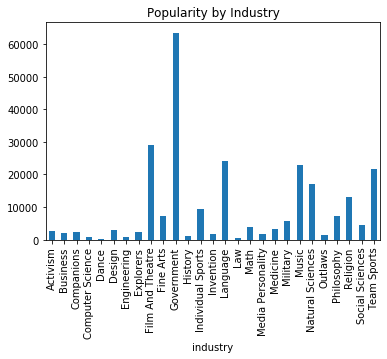

In [25]:
dfCleanData.groupby(['industry'])['popularity'].sum().plot.bar(title="Popularity by Industry")

In [26]:
dfTopMostPopular = pd.DataFrame(dfCleanData.sort_values(by = ['popularity'], ascending = False).loc[:,columnToDisplayCleanData].head(10))
dfTopMostPopular

,full_name,sex,birth_year,country,industry,domain,occupation,popularity
0,Aristotle,Male,-384,Greece,Philosophy,Humanities,Philosopher,31.9938
1,Plato,Male,-427,Greece,Philosophy,Humanities,Philosopher,31.9888
2,Jesus Christ,Male,-4,Israel,Religion,Institutions,Religious Figure,31.8981
3,Socrates,Male,-469,Greece,Philosophy,Humanities,Philosopher,31.6521
4,Alexander the Great,Male,-356,Greece,Military,Institutions,Military Personnel,31.5840
5,Leonardo da Vinci,Male,1452,Italy,Invention,Science & Technology,Inventor,31.4644
6,Confucius,Male,-551,China,Philosophy,Humanities,Philosopher,31.3705
7,Julius Caesar,Male,-100,Italy,Government,Institutions,Politician,31.1161
8,Homer,Male,-800,Turkey,Language,Humanities,Writer,31.1087
9,Pythagoras,Male,-570,Greece,Philosophy,Humanities,Philosopher,31.0691


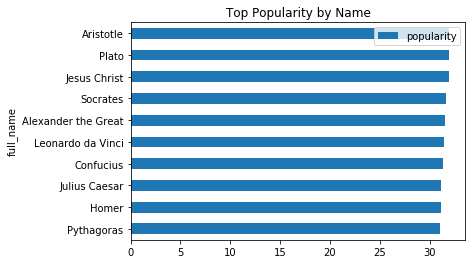

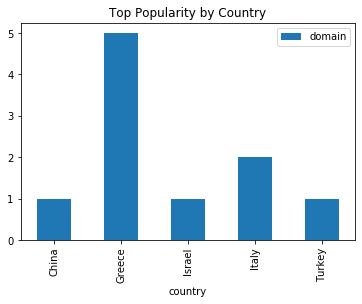

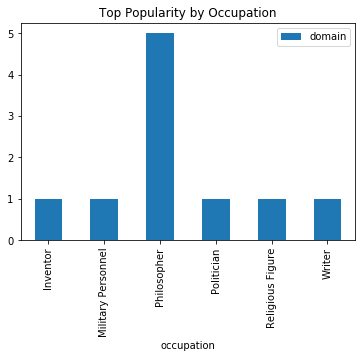

In [27]:
pd.DataFrame(dfTopMostPopular.groupby(['full_name'])['popularity'].sum()).sort_values(by = ['popularity'], ascending = True).plot.barh(title="Top Popularity by Name")
pd.DataFrame(dfTopMostPopular.groupby(['country'])['domain'].count()).plot.bar(title="Top Popularity by Country")
pd.DataFrame(dfTopMostPopular.groupby(['occupation'])['domain'].count()).plot.bar(title="Top Popularity by Occupation")

### Which historic characters are the most popular? When did they live and where are they from?
The table above are the top 10 of the historic characters are the most popular based on their popularity index. There are not many countries made the list.

In [28]:
dfTopLeastPopular = pd.DataFrame(dfCleanData.sort_values(by = ['popularity'], ascending = True).loc[:,columnToDisplayCleanData].head(10))
dfTopLeastPopular

,full_name,sex,birth_year,country,industry,domain,occupation,popularity
11340,Missy Franklin,Female,1995,United States,Individual Sports,Sports,Swimmer,9.8794
11339,Vladimír Weiss,Male,1989,Slovakia,Team Sports,Sports,Soccer Player,10.2495
11338,Rūta Meilutytė,Female,1997,Lithuania,Individual Sports,Sports,Swimmer,10.3821
11337,Saina Nehwal,Female,1990,India,Individual Sports,Sports,Athlete,10.6122
11336,Sean St Ledger,Male,1984,United Kingdom,Team Sports,Sports,Soccer Player,11.1346
11335,Jetro Willems,Male,1994,Netherlands,Team Sports,Sports,Soccer Player,11.3956
11334,Rebecca Soni,Female,1987,United States,Individual Sports,Sports,Swimmer,11.4050
11333,Sun Yang,Male,1991,China,Individual Sports,Sports,Swimmer,11.6234
11332,Shane Long,Male,1987,Ireland,Team Sports,Sports,Soccer Player,11.7174
11331,Marc Albrighton,Male,1989,United Kingdom,Team Sports,Sports,Soccer Player,11.7258


### Which historic characters are the least popular? When did they live and where are they from?
The table above are the top 10 of the historic characters are the least popular based on their popularity index. There are more countries made the list on the least popular crowd.

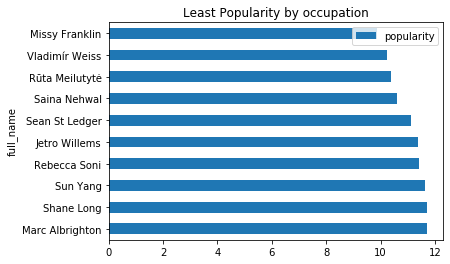

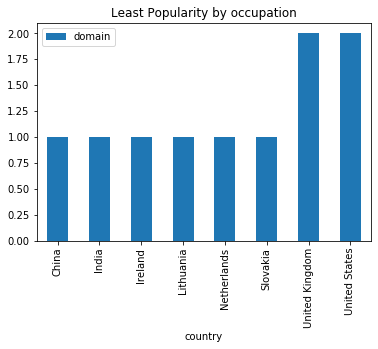

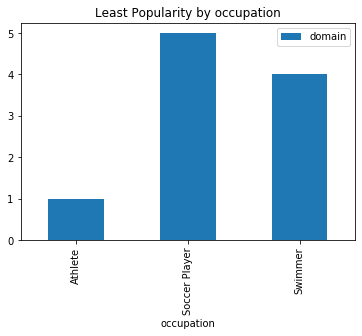

In [29]:
pd.DataFrame(dfTopLeastPopular.groupby(['full_name'])['popularity'].sum()).sort_values(by = ['popularity'], ascending = False).plot.barh(title="Least Popularity by occupation")
pd.DataFrame(dfTopLeastPopular.groupby(['country'])['domain'].count()).plot.bar(title="Least Popularity by occupation")
pd.DataFrame(dfTopLeastPopular.groupby(['occupation'])['domain'].count()).plot.bar(title="Least Popularity by occupation")

In [30]:
dfTotalBySex = pd.DataFrame(dfCleanData.groupby(['sex'])['article_id'].count())
dfTotalBySex.rename(columns={'article_id': 'total_count'}, inplace=True)
dfTotalBySex

,total_count
sex,
Female,1495
Male,9846


The total number of male vs. female in comparison.

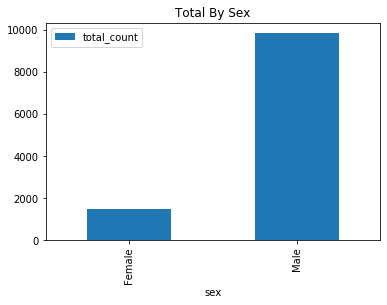

In [31]:
dfTotalBySex.plot.bar(title="Total By Sex")

In [32]:
dfTotalByContinentBySex = pd.DataFrame(dfCleanData.groupby(['industry','occupation','sex'])['article_id'].count())
dfTotalByContinentBySex.rename(columns={'article_id': 'total_count'}, inplace=True)
dfTotalByContinentBySex.sort_values(by = ['industry'], ascending =True).head(10)

total_count
industry         occupation         sex                
Activism         Social Activist    Female           38
                                    Male             76
Business         Businessperson     Female            4
                                    Male             75
                 Producer           Male             12
Companions       Companion          Female           94
                                    Male              7
Computer Science Computer Scientist Female            1
                                    Male             32
Dance            Dancer             Female            7

Generating a list of people by industry, occupation, and sex.

In [33]:
dfTotalByContinentBySex.sort_values(by = ['total_count'], ascending = False).head(10)

total_count
industry         occupation       sex                
Government       Politician       Male           2397
Team Sports      Soccer Player    Male           1059
Language         Writer           Male            844
Film And Theatre Actor            Male            692
                                  Female          501
Religion         Religious Figure Male            486
Music            Musician         Male            345
Philosophy       Philosopher      Male            275
Natural Sciences Physicist        Male            265
Music            Singer           Female          225

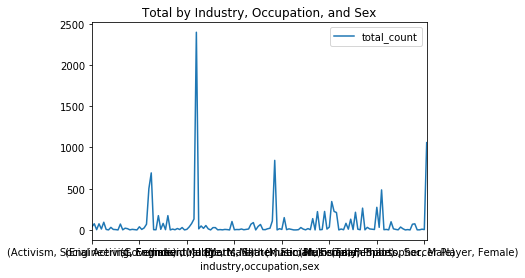

In [34]:
dfTotalByContinentBySex.plot.line(title="Total by Industry, Occupation, and Sex")

Generating a list of people by industry, occupation, and sex but sorting in decending order of total count.

In [35]:
#'Activism' 'Business', 'Companions', 'Computer Science' 'Dance' 'Design' 'Engineering' 'Explorers' 'Film And Theatre' 'Fine Arts'
#'Government' 'History' 'Individual Sports' 'Invention' 'Language' 'Law' 'Math' 'Media Personality' 'Medicine'
#'Military' 'Music' 'Natural Sciences' 'Outlaws' 'Philosophy' 'Religion' 'Social Sciences' 'Team Sports'
industry = 'Computer Science'
dfByIndustry = dfCleanData[dfCleanData['industry'] == industry].loc[:,columnToDisplayCleanData].sort_values(by = ['birth_year'], ascending = False)
dfByIndustry.head(10)

,full_name,sex,birth_year,country,industry,domain,occupation,popularity
9075,Sergey Brin,Male,1973,Russia,Computer Science,Science & Technology,Computer Scientist,19.4307
8734,Larry Page,Male,1973,United States,Computer Science,Science & Technology,Computer Scientist,20.0560
6165,Linus Torvalds,Male,1969,Finland,Computer Science,Science & Technology,Computer Scientist,22.7527
9562,Rasmus Lerdorf,Male,1968,Greenland,Computer Science,Science & Technology,Computer Scientist,18.4731
7016,Kevin Mitnick,Male,1963,United States,Computer Science,Science & Technology,Computer Scientist,22.1970
9461,Randy Pausch,Male,1960,United States,Computer Science,Science & Technology,Computer Scientist,18.6506
9533,Stephen Wolfram,Male,1959,United Kingdom,Computer Science,Science & Technology,Computer Scientist,18.5298
7626,Eric S. Raymond,Male,1957,United States,Computer Science,Science & Technology,Computer Scientist,21.6362
9296,Alexey Pazhitnov,Male,1956,Russia,Computer Science,Science & Technology,Computer Scientist,19.0038
9036,Guido van Rossum,Male,1956,Netherlands,Computer Science,Science & Technology,Computer Scientist,19.4986


The list of people based on the industry the are in. The parameter value the industry can be changed to look for specific one.

In [36]:
dfTopTenMostPopularPeople = dfCleanData.sort_values(by = ['popularity'], ascending = False)
dfTotalTop10ByCountry = pd.DataFrame(dfTopTenMostPopularPeople.groupby(['country'])['article_id'].count())
dfTotalTop10ByCountry.rename(columns={'article_id': 'total_count'}, inplace=True)
dfTotalTop10ByCountry.sort_values(by = ['total_count'], ascending = False).head(10)

,total_count
country,
United States,2169
United Kingdom,1147
France,867
Italy,809
Germany,748
Unknown,468
Russia,374
Spain,296
Turkey,204


Top ten highest numbers of people from each country.

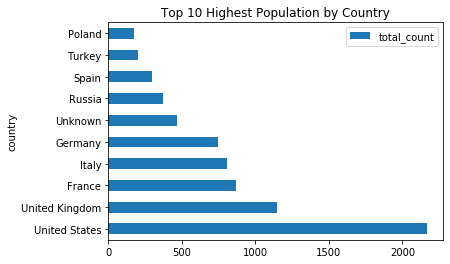

In [37]:
dfTotalTop10ByCountry.sort_values(by = ['total_count'], ascending = False).head(10).plot.barh(title="Top 10 Highest Population by Country")

In [38]:
dfTotalByContinent = pd.DataFrame(dfCleanData.groupby(['continent'])['article_id'].count())
dfTotalByContinent.rename(columns={'article_id': 'total_count'}, inplace=True)
dfTotalByContinent.sort_values(by = ['total_count'], ascending = False)

,total_count
continent,
Europe,6368
North America,2439
Asia,1188
Unknown,438
Africa,419
South America,366
Oceania,123


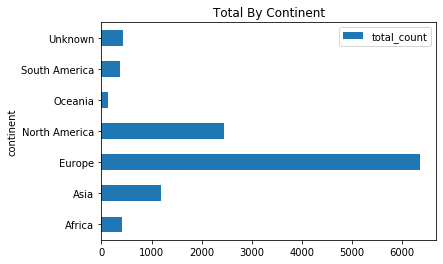

In [39]:
dfTotalByContinent.plot.barh(title="Total By Continent")

The list of total count for each continent

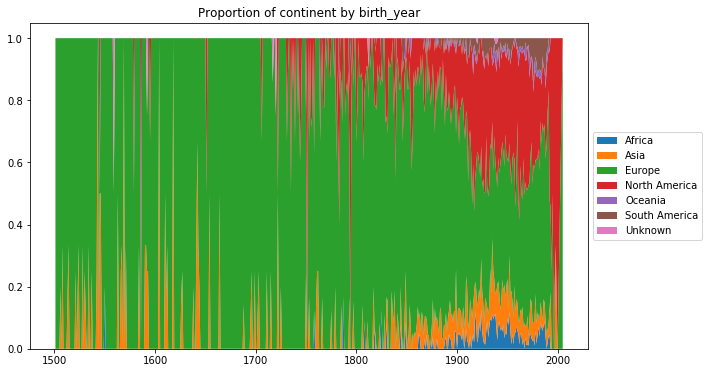

In [40]:
# Category trends by birth year = 'continent'
these_cols = ['continent','birth_year']
cat = these_cols[0]
year_limit = (dfCleanData['birth_year'] > 1500)
dfPlot = dfCleanData[these_cols][year_limit].set_index(cat).groupby(cat).apply(lambda g: g.apply(pd.value_counts)).unstack(level = 1).fillna(0).T
dfPlot = dfPlot.div(dfPlot.sum(axis = 1), axis = 0)
x = [year[1] for year in dfPlot.index.values]
y = np.array(dfPlot.T)
labels = dfPlot.columns.tolist()
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
ax.stackplot(x,y, labels = labels)
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), fancybox = True)
plt.title('Proportion of {:s} by {:s}'.format(these_cols[0], these_cols[1]))
plt.show()

For individuals born in the last 500 years, the proportion of those from Europe have trended lower and those from North America have trended higher. More individuals that are from Africa show up in the last 100 years.

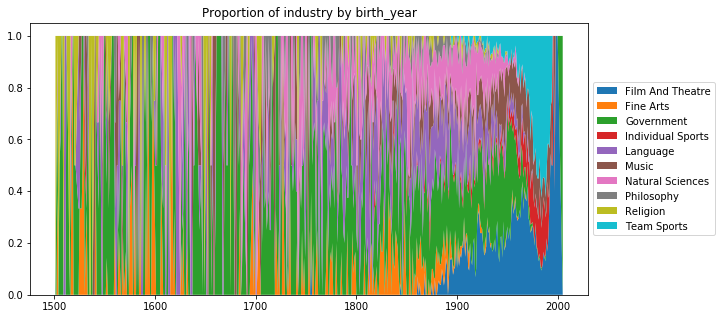

In [41]:
# Category trends by birth year = 'industry'
these_levels = dfCleanData['industry'].value_counts()[:10].index.tolist()
these_cols = ['industry','birth_year']
cat = these_cols[0]
year_limit = (dfCleanData['birth_year'] > 1500)
these_industries = dfCleanData['industry'].isin(these_levels)
dfPlot = dfCleanData[these_cols][year_limit & these_industries].set_index(cat).groupby(cat).apply(lambda g: g.apply(pd.value_counts)).unstack(level = 1).fillna(0).T
dfPlot = dfPlot.div(dfPlot.sum(axis = 1), axis = 0)
x = [year[1] for year in dfPlot.index.values]
y = np.array(dfPlot.T)
labels = dfPlot.columns.tolist()
fig, ax = plt.subplots()
fig.set_size_inches(10,5)
ax.stackplot(x,y, labels = labels)
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), fancybox = True)
plt.title('Proportion of {:s} by {:s}'.format(these_cols[0], these_cols[1]))
plt.show()

Top industries for people born in the last 500 years exhibit substantial variation and variety year after year up until 1900. Film and Team Sports can be seen trending higher. This might be due to the explosion in the film industry during 20th century and televised sports. With the changes in technology, the advancements in the marketing of these mediums of entertainment may have also contributed to this rise. The following displays the same industries excluding Film and Theatre, Team Sports, Individual Sports, Music, and Fine Arts.

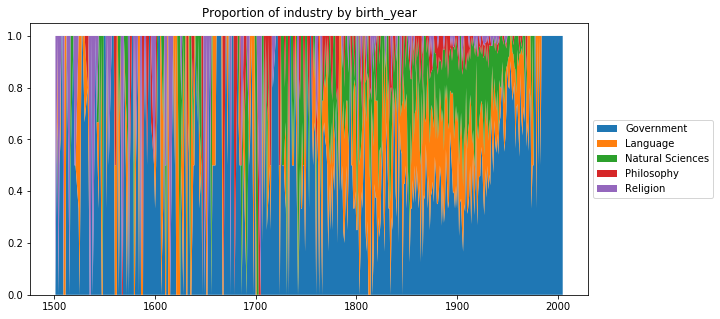

In [42]:
exclude_these = ['Film And Theatre','Team Sports','Individual Sports','Music','Fine Arts']
fewer_industries = [i for i in these_levels if i not in exclude_these]
these_industries = dfCleanData['industry'].isin(fewer_industries)
dfPlotSub = dfCleanData[these_cols][year_limit & these_industries].set_index(cat).groupby(cat).apply(lambda g: g.apply(pd.value_counts)).unstack(level = 1).fillna(0).T
dfPlotSub = dfPlotSub.div(dfPlotSub.sum(axis = 1), axis = 0)

x = [year[1] for year in dfPlotSub.index.values]
y = np.array(dfPlotSub.T)
labels = dfPlotSub.columns.tolist()
fig, ax = plt.subplots()
fig.set_size_inches(10,5)
ax.stackplot(x,y, labels = labels)
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), fancybox = True)
plt.title('Proportion of {:s} by {:s}'.format(these_cols[0], these_cols[1]))
plt.show()

If industries associated with entertainment are excluded, there can be seen an increase in the proportion of Government figures. Prominent individuals in Natural Sciences exhibit a substantial decrease in proportion from early 20th century levels. Interestingly there is a strong representation of Language from the mid-20th century to about 1980. Who are they?

In [43]:
year_limits = (dfCleanData['birth_year'] > 1950) & (dfCleanData['birth_year'] < 1980)
industry_limit = (dfCleanData['industry'] == 'Language')
dfCleanData[year_limits & industry_limit].sort_values(by = ['popularity'], ascending = False)['full_name'].head(10)

1900             Orhan Pamuk
4033         Jostein Gaarder
5227               Dan Brown
5270            John Grisham
5322           Stieg Larsson
5910           J. K. Rowling
6655    Arturo Pérez-Reverte
6705            Clive Barker
6837      Anna Politkovskaya
7057      Michel Houellebecq
Name: full_name, dtype: object

The results show that several novelists, born between 1950 and 1980, experienced high popularity on Wikipedia.

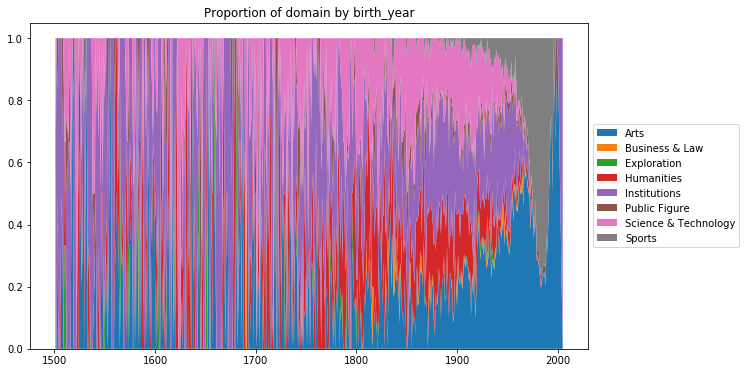

In [44]:
# Category trends by birth year = 'domain'
these_cols = ['domain','birth_year']
cat = these_cols[0]
year_limit = (dfCleanData['birth_year'] > 1500)
dfPlot = dfCleanData[these_cols][year_limit].set_index(cat).groupby(cat).apply(lambda g: g.apply(pd.value_counts)).unstack(level = 1).fillna(0).T
dfPlot = dfPlot.div(dfPlot.sum(axis = 1), axis = 0)
x = [year[1] for year in dfPlot.index.values]
y = np.array(dfPlot.T)
labels = dfPlot.columns.tolist()
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
ax.stackplot(x,y, labels = labels)
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), fancybox = True)
plt.title('Proportion of {:s} by {:s}'.format(these_cols[0], these_cols[1]))
plt.show()

The above plot supports the findings around the industries that experienced high popularity through the domains of the Arts and Sports. These two domains exhibited the highest proportion of popularity for individuals born in the latter 20th century.

## Modeling

This section will explore the data by clustering. By examining the centroids of each cluster, we should be able to distinguish the features that most distinguish the Pantheon.

In [45]:
dfModel = dfCleanData # data frame for modeling

Drop Irrelevant Variables. These include article_id, full_name, city, and state. 

In [46]:
drop_these = ['article_id','full_name','city','state']
if any([x in dfModel.columns.tolist() for x in drop_these]):
    dfModel = dfModel.drop(drop_these, axis = 1)

In [47]:
dfModel.dtypes

sex                   object
birth_year             int64
country               object
continent             object
latitude             float64
longitude            float64
occupation            object
industry              object
domain                object
article_languages      int64
page_views             int64
average_views          int64
popularity           float64
dtype: object

Transform categorical variables; create new dummy variables.

In [48]:
# creating dummy variables for the columns that were objects
cat_vars = ['sex','country','continent','occupation','industry','domain']
dfDummies = pd.get_dummies(dfModel[cat_vars])
dfDummies.shape

(11341, 327)

There are 327 new dummy variables.

In [49]:
# bind the modeling data with dummy variables
dfModel1 = pd.concat([dfModel, dfDummies], axis = 1)
dfModel1.shape

(11341, 340)

In [50]:
# drop original columns corresponding to dummy variables (i.e. categorical variables)
drop_vars = [dfModel1.columns.get_loc(x) for x in cat_vars]
dfModel2 = dfModel1.drop(dfModel1.columns[drop_vars], axis = 1)
dfModel2.shape

(11341, 334)

These six categorical variables were removed and replaced with new dummy variables.

In [51]:
cat_vars

['sex', 'country', 'continent', 'occupation', 'industry', 'domain']

In [52]:
dfModel2.head()

,birth_year,latitude,longitude,article_languages,page_views,average_views,popularity,sex_Female,sex_Male,country_Afghanistan,...,industry_Social Sciences,industry_Team Sports,domain_Arts,domain_Business & Law,domain_Exploration,domain_Humanities,domain_Institutions,domain_Public Figure,domain_Science & Technology,domain_Sports
0,-384,40.33333,23.50000,152,56355172,370758,31.9938,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,-427,37.96667,23.71667,142,46812003,329662,31.9888,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,-4,32.50000,34.90000,214,60299092,281771,31.8981,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,-469,37.96667,23.71667,137,40307143,294213,31.6521,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,-356,40.80000,22.51667,138,48358148,350421,31.5840,0,1,0,...,0,0,0,0,0,0,1,0,0,0


For clustering, all object-type variables should be dropped.

In [53]:
dfModel2.dtypes.value_counts()

uint8      327
int64        4
float64      3
dtype: int64

Prior to clustering, data needs to be scaled and normalized.

In [54]:
stscaler = StandardScaler().fit(dfModel2)
dfModel2Norm = stscaler.transform(dfModel2)
print("As a result of scaling, the mean of the data is {:.2f}".format(np.mean(dfModel2Norm)))

As a result of scaling, the mean of the data is -0.00


### DBSCAN

This is a density-based clustering technique that automatically detects a clustering. The default parameters were used:
* eps (epsilon radius) = 0.5
* min_samples = 5

In [55]:
#Run the DBSCAN algorithm on Data to construct a DBSCAN object

db = DBSCAN().fit(dfModel2Norm)

In [56]:
# define the indices where dbscan was able to cluster the points.
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

In [57]:
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 205


In [58]:
unique, counts = np.unique(labels, return_counts = True)
clustering = dict(zip(unique, counts))
clustering = [x for x in clustering.values()]

In [59]:
print("DSCAN was not able to assign {:d} individuals to a cluster. These individuals are considered outliers.".format(clustering[0]))

DSCAN was not able to assign 7349 individuals to a cluster. These individuals are considered outliers.


In [60]:
# outliers
outliers = dfCleanData.loc[labels == -1,]
outliers.describe()

,article_id,birth_year,latitude,longitude,article_languages,page_views,average_views,popularity
count,7.349000e+03,7349.000000,7349.000000,7349.000000,7349.000000,7.349000e+03,7.349000e+03,7349.000000
mean,2.595247e+06,1699.452306,34.566198,-3.324383,43.318411,5.418337e+06,1.086717e+05,22.247384
std,6.256401e+06,646.077402,22.138535,57.385594,20.080753,9.130970e+06,1.387243e+05,3.537447
min,3.070000e+02,-3500.000000,-51.633330,-175.200560,26.000000,1.965000e+03,4.900000e+01,9.879400
25%,6.678900e+04,1840.000000,31.200000,-9.139440,30.000000,8.101690e+05,2.368700e+04,20.031200
50%,2.919840e+05,1929.000000,41.442590,3.916670,37.000000,2.210700e+06,5.547100e+04,22.859200
75%,1.061307e+06,1964.000000,49.798890,21.016670,50.000000,6.255570e+06,1.381410e+05,24.710600
max,3.864696e+07,2005.000000,70.073330,178.017780,214.000000,1.452506e+08,1.515232e+06,31.993800


In [61]:
avg_cluster = int(round(np.mean(clustering)))
remaining_not_outliers = dfModel2Norm.shape[0] - clustering[0]
print("For the remaining {:d} individuals, the DBSCAN clustering technique was able to assign {:d} individuals to a cluster on average.".format(remaining_not_outliers, avg_cluster))

For the remaining 3992 individuals, the DBSCAN clustering technique was able to assign 55 individuals to a cluster on average.


Top 10 clusters by Popularity

In [62]:
dfEval = dfCleanData
dfEval['cluster'] = labels

In [78]:
dfTop10Clusters = pd.DataFrame(dfEval.groupby(['cluster'])['popularity'].mean())
dfTop10Clusters['size'] = dfEval.groupby(['cluster'])['article_id'].count() # size: count of individuals
dfTop10Clusters['avg_views'] = dfEval.groupby(['cluster'])['average_views'].mean().round().astype(int) # mean: average_views
dfTop10Clusters['avg_page_views'] = dfEval.groupby(['cluster'])['page_views'].mean().round().astype(int) # mean: page_views
dfTop10Clusters['avg_languages'] = dfEval.groupby(['cluster'])['article_languages'].mean().round().astype(int) # mean: article_languages

In [79]:
dfTop10Clusters.sort_values(by = ['popularity'], ascending = False).head(10)

,popularity,size,avg_views,avg_page_views,avg_languages
cluster,,,,,
0,27.005060,5,150168,10748552,72
2,26.712400,7,44206,1711392,39
1,26.483517,12,23322,1233045,51
11,26.074620,5,27047,902643,33
4,25.992154,13,14250,656663,44
16,25.912375,4,23316,1554655,67
21,25.623560,5,152114,8972884,60
28,25.606467,6,37262,1941450,52
24,25.592100,5,31863,1325400,41


**The following are individuals that are part of the most popular cluster.**

In [80]:
exclCols = ['article_id','latitude','longitude'] # columns to exclude in print
keepCols = [col for col in dfEval.columns if col not in exclCols]
dfEval[keepCols].loc[labels == 0,]

,full_name,sex,birth_year,city,state,country,continent,occupation,industry,domain,article_languages,page_views,average_views,popularity,cluster
289,Charles Baudelaire,Male,1821,Paris,Unknown,France,Europe,Writer,Language,Humanities,70,12673471,181050,27.5592,0
329,Émile Zola,Male,1840,Paris,Unknown,France,Europe,Writer,Language,Humanities,72,10586574,147036,27.4237,0
353,Arthur Rimbaud,Male,1854,Charleville-Mézières,Unknown,France,Europe,Writer,Language,Humanities,72,9619541,133605,27.3636,0
791,Antoine de Saint-Exupéry,Male,1900,Lyon,Unknown,France,Europe,Writer,Language,Humanities,76,9899518,130257,26.3445,0
799,Guy de Maupassant,Male,1850,Tourville-sur-Arques,Unknown,France,Europe,Writer,Language,Humanities,69,10963658,158894,26.3343,0


These all appear to be french writers born in the 1800s.

**The following are individuals that are part of the second most popular cluster.**

In [81]:
dfEval[keepCols].loc[labels == 2,]

,full_name,sex,birth_year,city,state,country,continent,occupation,industry,domain,article_languages,page_views,average_views,popularity,cluster
334,Enoch,Male,-3500,Other,Unknown,Unknown,Unknown,Religious Figure,Religion,Institutions,36,1150313,31953,27.4143,2
376,Japheth,Male,-3500,Other,Unknown,Unknown,Unknown,Religious Figure,Religion,Institutions,38,1325651,34886,27.2905,2
482,Lot,Male,-3500,Other,Unknown,Unknown,Unknown,Religious Figure,Religion,Institutions,44,1093210,24846,27.0033,2
491,Shem,Male,-3500,Other,Unknown,Unknown,Unknown,Religious Figure,Religion,Institutions,38,1623581,42726,26.9857,2
684,Nimrod,Male,-3500,Other,Unknown,Unknown,Unknown,Religious Figure,Religion,Institutions,38,3573828,94048,26.5561,2
941,Seth,Male,-3500,Other,Unknown,Unknown,Unknown,Religious Figure,Religion,Institutions,40,2197060,54927,26.1374,2
1414,Ham,Male,-3443,Other,Unknown,Unknown,Unknown,Religious Figure,Religion,Institutions,39,1016102,26054,25.5995,2


These all appear to be popular religious figures of unknown geographic origin. They might be biblical figures, given their names and birth years.

**The following are individuals that are part of the third most popular cluster.**

In [82]:
dfEval[keepCols].loc[labels == 1,]

,full_name,sex,birth_year,city,state,country,continent,occupation,industry,domain,article_languages,page_views,average_views,popularity,cluster
239,Antoninus Pius,Male,86,Lanuvium,Unknown,Italy,Europe,Politician,Government,Institutions,63,2326411,36927,27.7767,1
348,Otho,Male,32,Viterbo,Unknown,Italy,Europe,Politician,Government,Institutions,56,1391145,24842,27.3792,1
359,Galba,Male,-3,Terracina,Unknown,Italy,Europe,Politician,Government,Institutions,56,1700135,30360,27.3398,1
603,Gordian III,Male,225,Rome,Unknown,Italy,Europe,Politician,Government,Institutions,48,834707,17390,26.7153,1
690,Lucius Verus,Male,130,Rome,Unknown,Italy,Europe,Politician,Government,Institutions,46,1220079,26523,26.5485,1
748,Didius Julianus,Male,137,Milan,Unknown,Italy,Europe,Politician,Government,Institutions,53,1071432,20216,26.4135,1
829,Trebonianus Gallus,Male,206,Perugia,Unknown,Italy,Europe,Politician,Government,Institutions,49,558827,11405,26.2764,1
850,Elagabalus,Male,203,Rome,Unknown,Italy,Europe,Politician,Government,Institutions,54,2579715,47773,26.2491,1
903,Valentinian III,Male,419,Ravenna,Unknown,Italy,Europe,Politician,Government,Institutions,48,1010924,21061,26.1822,1
947,Pertinax,Male,126,Alba Pompeia,Unknown,Italy,Europe,Politician,Government,Institutions,51,1241066,24335,26.1301,1


These individuals appear to be famous Roman/Italian government figures from the 0-500 AD period.

# Results

# Conclusion